In [11]:
dataDir_paths = ['/data/willett_data/competitionData/', 
                 '/home3/skaasyap/willett/competitionData/']
dataSave_paths = ['/data/willett_data/ptDecoder_ctc',
                  '/data/willett_data/ptDecoder_ctc_both',
                      '/home3/skaasyap/willett/data', 
                      '/home3/skaasyap/willett/data_log', 
                      '/home3/skaasyap/willett/data_log_both']
dataDir = dataDir_paths[0]
dataSave = dataSave_paths[1]
print(dataDir)
print(dataSave)

/data/willett_data/competitionData/
/data/willett_data/ptDecoder_ctc_both


In [2]:
sessionNames = ['t12.2022.04.28',  't12.2022.05.26',  't12.2022.06.21',  't12.2022.07.21',  't12.2022.08.13',
't12.2022.05.05',  't12.2022.06.02',  't12.2022.06.23',  't12.2022.07.27',  't12.2022.08.18',
't12.2022.05.17',  't12.2022.06.07',  't12.2022.06.28',  't12.2022.07.29',  't12.2022.08.23',
't12.2022.05.19',  't12.2022.06.14',  't12.2022.07.05',  't12.2022.08.02',  't12.2022.08.25',
't12.2022.05.24',  't12.2022.06.16',  't12.2022.07.14',  't12.2022.08.11']
sessionNames.sort()

In [3]:
import re 
from g2p_en import G2p
import numpy as np

g2p = G2p()
PHONE_DEF = [
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B',  'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH'
]
PHONE_DEF_SIL = PHONE_DEF + ['SIL']

def phoneToId(p):
    return PHONE_DEF_SIL.index(p)

In [4]:
def reorder_electrode_idxs(feats):
    
    area_6v_superior = np.array([
    [62,  51,  43,  35,  94,  87,  79,  78],
    [60,  53,  41,  33,  95,  86,  77,  76],
    [63,  54,  47,  44,  93,  84,  75,  74],
    [58,  55,  48,  40,  92,  85,  73,  72],
    [59,  45,  46,  38,  91,  82,  71,  70],
    [61,  49,  42,  36,  90,  83,  69,  68],
    [56,  52,  39,  34,  89,  81,  67,  66],
    [57,  50,  37,  32,  88,  80,  65,  64]
    ])
    
    # Create the new array by interleaving x and x + 128
    superior_combined_array = np.empty(area_6v_superior.size * 2, dtype=area_6v_superior.dtype)  
    superior_combined_array[::2] = area_6v_superior.ravel()
    superior_combined_array[1::2] = area_6v_superior.ravel() + 128   

    area_6v_inferior = np.array([
        [125, 126, 112, 103,  31,  28,  11,  8],
        [123, 124, 110, 102,  29,  26,   9,  5],
        [121, 122, 109, 101,  27,  19,  18,  4],
        [119, 120, 108, 100,  25,  15,  12,  6],
        [117, 118, 107,  99,  23,  13,  10,  3],
        [115, 116, 106,  97,  21,  20,   7,  2],
        [113, 114, 105,  98,  17,  24,  14,  0],
        [127, 111, 104,  96,  30,  22,  16,  1]
    ])
    
    # Create the new array by interleaving x and x + 128
    inferior_combined_array = np.empty(area_6v_inferior.size * 2, dtype=area_6v_inferior.dtype)  
    inferior_combined_array[::2] = area_6v_inferior.ravel()
    inferior_combined_array[1::2] = area_6v_inferior.ravel() + 128   
    
    feats_reshaped = np.zeros_like(feats)
    
    feats_reshaped[:, 0:128] = feats[:, inferior_combined_array.ravel()]
    feats_reshaped[:, 128:] = feats[:, superior_combined_array.ravel()]
    
    return feats_reshaped
    

In [5]:
import torch
x = np.expand_dims(np.arange(256),axis=0)
x_reordered = np.expand_dims(reorder_electrode_idxs(x), axis=0)
x_reordered = torch.asarray(np.tile(x_reordered, (1, 1, 32, 1)) )
print(x_reordered.shape)

from einops.layers.torch import Rearrange
from einops.layers.torch import Rearrange
patch_height = 32
patch_width = 2
rearrange_layer = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width)

x_einsum = rearrange_layer(x_reordered)
x_einsum[0, 1]

torch.Size([1, 1, 32, 256])


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


tensor([126, 254, 126, 254, 126, 254, 126, 254, 126, 254, 126, 254, 126, 254,
        126, 254, 126, 254, 126, 254, 126, 254, 126, 254, 126, 254, 126, 254,
        126, 254, 126, 254, 126, 254, 126, 254, 126, 254, 126, 254, 126, 254,
        126, 254, 126, 254, 126, 254, 126, 254, 126, 254, 126, 254, 126, 254,
        126, 254, 126, 254, 126, 254, 126, 254])

In [6]:
import scipy

def loadFeaturesAndNormalize(sessionPath, logPower=True, logBoth=True):
    
    dat = scipy.io.loadmat(sessionPath)

    input_features = []
    transcriptions = []
    frame_lens = []
    block_means = []
    block_stds = []
    n_trials = dat['sentenceText'].shape[0]

    #collect area 6v tx1 and spikePow features
    for i in range(n_trials):    
        #get time series of TX and spike power for this trial
        #first 128 columns = area 6v only
        if logPower:
            tx_crossings = dat['tx1'][0, i][:, 0:128]
            log_pow = np.log(dat['spikePow'][0,i][:,0:128])
            features = np.concatenate([tx_crossings, log_pow], axis=1)
        if logBoth:
            tx_crossings = np.log1p(dat['tx1'][0, i][:, 0:128])
            log_pow = np.log(dat['spikePow'][0,i][:,0:128])
            features = np.concatenate([tx_crossings, log_pow], axis=1)
        else:
            features = np.concatenate([dat['tx1'][0,i][:,0:128], dat['spikePow'][0,i][:,0:128]], axis=1)

        sentence_len = features.shape[0]
        sentence = dat['sentenceText'][i].strip()

        input_features.append(features)
        transcriptions.append(sentence)
        frame_lens.append(sentence_len)

    #block-wise feature normalization
    blockNums = np.squeeze(dat['blockIdx'])
    blockList = np.unique(blockNums)
    blocks = []
    for b in range(len(blockList)):
        sentIdx = np.argwhere(blockNums==blockList[b])
        sentIdx = sentIdx[:,0].astype(np.int32)
        blocks.append(sentIdx)

    for b in range(len(blocks)):
        feats = reorder_electrode_idxs(np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0))
        # feats = np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0)

        feats_mean = np.mean(feats, axis=0, keepdims=True)
        feats_std = np.std(feats, axis=0, keepdims=True)
        for i in blocks[b]:
            input_features[i] = reorder_electrode_idxs(input_features[i])
            input_features[i] = (input_features[i] - feats_mean) / (feats_std + 1e-8)

    #convert to tfRecord file
    session_data = {
        'inputFeatures': input_features,
        'transcriptions': transcriptions,
        'frameLens': frame_lens
    }

    return session_data


In [7]:
import os

def getDataset(fileName):
    session_data = loadFeaturesAndNormalize(fileName)
        
    allDat = []
    trueSentences = []
    seqElements = []
    
    for x in range(len(session_data['inputFeatures'])):
        allDat.append(session_data['inputFeatures'][x])
        trueSentences.append(session_data['transcriptions'][x])
        
        thisTranscription = str(session_data['transcriptions'][x]).strip()
        thisTranscription = re.sub(r'[^a-zA-Z\- \']', '', thisTranscription)
        thisTranscription = thisTranscription.replace('--', '').lower()
        addInterWordSymbol = True

        phonemes = []
        for p in g2p(thisTranscription):
            if addInterWordSymbol and p==' ':
                phonemes.append('SIL')
            p = re.sub(r'[0-9]', '', p)  # Remove stress
            if re.match(r'[A-Z]+', p):  # Only keep phonemes
                phonemes.append(p)

        #add one SIL symbol at the end so there's one at the end of each word
        if addInterWordSymbol:
            phonemes.append('SIL')

        seqLen = len(phonemes)
        maxSeqLen = 500
        seqClassIDs = np.zeros([maxSeqLen]).astype(np.int32)
        seqClassIDs[0:seqLen] = [phoneToId(p) + 1 for p in phonemes]
        seqElements.append(seqClassIDs)

    newDataset = {}
    newDataset['sentenceDat'] = allDat
    newDataset['transcriptions'] = trueSentences
    newDataset['phonemes'] = seqElements
    
    timeSeriesLens = []
    phoneLens = []
    for x in range(len(newDataset['sentenceDat'])):
        timeSeriesLens.append(newDataset['sentenceDat'][x].shape[0])
        
        zeroIdx = np.argwhere(newDataset['phonemes'][x]==0)
        phoneLens.append(zeroIdx[0,0])
    
    newDataset['timeSeriesLens'] = np.array(timeSeriesLens)
    newDataset['phoneLens'] = np.array(phoneLens)
    newDataset['phonePerTime'] = newDataset['phoneLens'].astype(np.float32) / newDataset['timeSeriesLens'].astype(np.float32)
    return newDataset

In [8]:
trainDatasets = []
testDatasets = []
competitionDatasets = []


for dayIdx in range(len(sessionNames)):
    trainDataset = getDataset(dataDir + '/train/' + sessionNames[dayIdx] + '.mat')
    testDataset = getDataset(dataDir + '/test/' + sessionNames[dayIdx] + '.mat')

    trainDatasets.append(trainDataset)
    testDatasets.append(testDataset)

    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        dataset = getDataset(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat')
        competitionDatasets.append(dataset)

In [56]:
competitionDays = []
for dayIdx in range(len(sessionNames)):
    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        competitionDays.append(dayIdx)
print(competitionDays)

[4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20]


In [12]:
import pickle

allDatasets = {}
allDatasets['train'] = trainDatasets
allDatasets['test'] = testDatasets
allDatasets['competition'] = competitionDatasets

with open(dataSave, 'wb') as handle:
    pickle.dump(allDatasets, handle)

In [58]:
trainDataset['sentenceDat'][0].std()

1.0451229

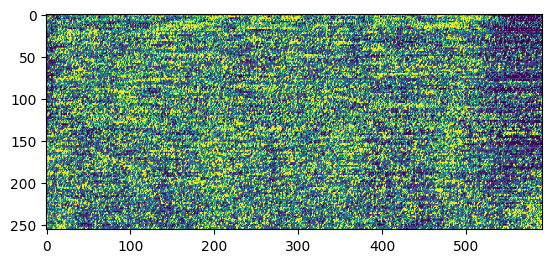

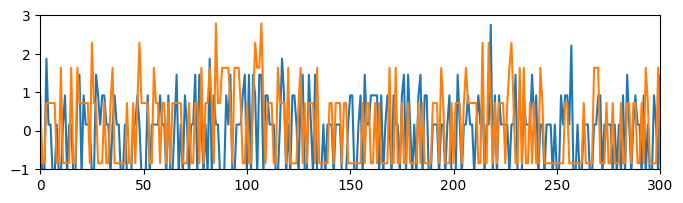

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(trainDatasets[0]['sentenceDat'][10].T, clim=[-1,1])
plt.show()

plt.figure(figsize=(8,2))
plt.plot(trainDatasets[0]['sentenceDat'][10][:,0])
plt.plot(trainDatasets[0]['sentenceDat'][10][:,128])
plt.xlim([0,300])
plt.ylim([-1,3])
plt.show()

In [7]:
import pickle
with open('/home3/skaasyap/willett/data_log_both', mode='rb') as handle:
    data_log_both = pickle.load(handle)
    
with open('/home3/skaasyap/willett/data_log', mode='rb') as handle:
    data_log = pickle.load(handle)

In [19]:
import numpy as np

In [22]:
#np.array_equal(data_log['train'][0]['sentenceDat'][0], data_log_both['train'][0]['sentenceDat'][0])

False